# Microeconometrics Project - Are Credit Markets Still Local? Evidence from Bank Branch Closings. 

## Introduction
Scope of this Project is to replicate a the study **"Are Credit Markets Still Local? Evidence from Bank Branch Closings."** written by **Hoai-Luu Q. Nguyen**  published in *AMERICAN ECONOMIC JOURNAL: APPLIED ECONOMICS VOL. 11, NO. 1, JANUARY 2019*. <br> <br>

Data and Stata-files are provided by the American Economic Association:<br>
<href>https://www.aeaweb.org/articles?id=10.1257/app.20170543</href><br>



**Hyothesis:** Does the distance to bank branches effect credit allocation?<br>

**Identification Issue:** Openings and closings of bank branches are not random assignments<br>

**Idea:** Using the impact of post-merger branch closings to measure the effect on lending <br>
          => *Key assumption:* merger decision is exogenous to local economic conditions (census tract)
          
**Data:**

        * census tract -> macro- and household data on tract level
        * Summary of Deposits -> branch data
        * Report of Changes -> merger and branch closing 
        * HMDA and CRA -> lending data
        
**Method:** 

        1. IV – “exposure to post-merger consolidation” as instrument for closings
	    2. DiD – to compare lending in exposed and control (census) tracts in the same county 

*Why does the author use two methods? - to allow for heterogeneity across tracts within a county (DiD)*

## Abstract
*This paper studies whether distance shapes credit allocation by estimating the impact of bank branch closings during the 2000s on local access to credit. To generate plausibly exogenous variation in the incidence of closings, I use an instrument based on within-county, tract-level variation in exposure to post-merger branch consolidation. Closings lead to a persistent decline in local small business lending. Annual originations fall by 453K USD after a closing, off a baseline of 4.7 million USD, and remain depressed for up to 6 years. The effects are very localized, dissipating within 6 miles, and are especially severe during the financial crisis.*

## Data and Methodology
The Author uses three main data sources. First, as the main source she uses the *census tract* published by the US Census Bureau. This tracts vary in size across different regions, while containing 4000 inhabitans. <br>
Second as to instrument exposure, she uses the data from the FDIC called *Summary of Deposits (SOD)*. This data set provides data on branches e.g. location, deposists, latitude and longitude. <br> 
Finally, data on merger activity and branch closings is provided by FDIC *Report of Changes*. Further data on loans and lenders is provided by the FFIEC *Home Mortgage Disclosure Act (HMDA)* and *Community Reinvestment Act (CRA)*<br>
Macroeconomic data is used from the *National Establishment Time-Series (NETS)* by Walls and Associates.<br> 
Datasets are merged on bank- and tract-level by using **GIS** software to map locations. 
In the end the sample consists of tracts based on exposure to large bank mergers. Data are for the 1999-2012 period. <br> <br>

In the first step the author tests whether branch closing affects local credit supply.
Since we can not rule out potential simultaneity issues between branch closing and credit supply, the athor uses an IV approach.
$$\text{Close}_{it} = \kappa_i + \psi_t + \rho X_{it} + \beta_e \text{Expose}_{it} + \omega_{it}$$
$$ y_{it} = \alpha_i + \gamma_t + \lambda X_{it} + \beta_c \text{Close}_{it} + \epsilon_{it} $$
Further to address the issue that the decision for a merger is not turely exogenous Nguyen expands her anaylsis by an Difference-in-Differences Approach. To compare tracts who experienced a merger and tracts without (treated and control tracts/groups) within a county. 
$$y_{icmt} = \alpha_i + (\gamma_t \times \sigma_c) + X_i \beta_t + \sum_{\tau} \delta_{\tau} (D_{mt}^{\tau} \times \text{Expose}_{icm}) + \epsilon_{icmt}$$
Where tract $i$ in county $c$ experienced merger $m$ in year $t$. $D_{mt}^{\tau}$ is a dummy variable equals one in year $t$ and $\tau$ years after merger $m$ is approved. The reduced model is independent of $\tau$, thus:
$$y_{icmt} = \alpha_i + (\gamma_t \times \sigma_c) + X_i \beta_t + \delta_{\text{POST}} (\text{POST}_{mt} \times \text{Closure}_{icm}) + \epsilon_{icmt}$$

## Causal Graph and Identification Issues

### Causal Graph 

![](graphs/causal_graph.png)

    * D - treatment variable "bank branch closings"
    * Y - dependend variable "lending activity"
    * X - bank specific controls
    * E - general economic controls
    * L - local economic controls
    * M - instrument "merger activity"
    * U - unobserved drivers of lending activity

### Identification 
The causal graph above pins down the relationships between banking and lending. There are multiple collider varibales, backdoorpaths, confounding varibales and reverse causality issues need to be solved to show causality. 

First consider our variable of interest, lending activiy. Since credit is an equilibirum concept, 
its very difficult to disentangle whether a change in lending activity is diven by a change in credit demand or supply. Second our treatment variable, bank branch closings, has an issue of reverse causality with lending activity. One can argue, that less demand for credit is affecting banks decision to close a branch in a certain location. While, we are testing whether the closing of a branch in a certain location affects credit availibility. This issues, can be solved by instrumenting bank branch closing with merger activity. The author argues, that the decision to close a branch after a merger is more driven by merger activity less then by local demand of lending. By controlling for bankspecific characteristics and general economic conditions the backdoor paths over $X$ and $E$ are blocked. Thus, the exogeneity and relevance conditions should be fullfilled.

Finally, two backdoorpaths need to be blocked. Which is done by controlling for general- ($E$) and local economic ($L$) conditions.

Since tracts and counties are differ in various characteristics, a concern on heterogeneity across tracts arises. The IV-approach is not able to control for such unobserved time invariante individual tract characteristics. Therefore the author expands the analysis by a difference in differences approach (DiD). This panel data method allows to account for heterogeneity. The idea is to compair treated and non-treated tracts within a county, while controlling for tract fixed-effects. General economic conditions within a county should be compairable, such that heterogeneity is not driving the results anymore. 

In [1]:
%reset -f
%clear
%load_ext autoreload

# preface loading packages required for Python Data Science
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

In [16]:
# import dataset provided by AEA and inspect data structure
df = pd.read_stata('data/replication_input.dta')
df.head()

,state_fps,cnty_fps,mergerID,approved,acq_instname,out_instname,yr_approve,tractstring,overlap,year,...,premerger_acqbranches,premerger_acqstates,premerger_acqcounties,premerger_outasset,premerger_outbranches,premerger_outstates,premerger_outcounties,sum_amt_notCRA,sum_amt_CRA,amt_MBLS_branchonly
0,1,3,49,2006-10-20,Regions Bank,AmSouth Bank,2006,105,1,1999,...,1298,15,397,53899220,648,6,134,7254,29740,0
1,1,3,49,2006-10-20,Regions Bank,AmSouth Bank,2006,105,1,2000,...,1298,15,397,53899220,648,6,134,14636,34317,0
2,1,3,49,2006-10-20,Regions Bank,AmSouth Bank,2006,105,1,2001,...,1298,15,397,53899220,648,6,134,6288,43143,0
3,1,3,49,2006-10-20,Regions Bank,AmSouth Bank,2006,105,1,2002,...,1298,15,397,53899220,648,6,134,5909,48725,0
4,1,3,49,2006-10-20,Regions Bank,AmSouth Bank,2006,105,1,2003,...,1298,15,397,53899220,648,6,134,5132,53024,0


In [3]:
# looking for missing values
# df.isnull().sum()
# df.dropna()

In [4]:
# some summary statistics
df.describe()

,state_fps,cnty_fps,mergerID,yr_approve,overlap,year,totalbranches,brgrowth,total_origin,NumSBL_Rev1,...,premerger_acqbranches,premerger_acqstates,premerger_acqcounties,premerger_outasset,premerger_outbranches,premerger_outstates,premerger_outcounties,sum_amt_notCRA,sum_amt_CRA,amt_MBLS_branchonly
count,52095.000000,52095.000000,52095.00000,52095.000000,52095.000000,52095.000000,52071.000000,44433.000000,47210.000000,45864.000000,...,52095.000000,52095.000000,52095.000000,5.209500e+04,52095.000000,52095.000000,52095.000000,47625.000000,4.762500e+04,1.646200e+04
mean,25.465592,90.000864,43.77282,2005.228027,0.111143,2006.000122,4.011619,0.038607,196.429310,70.331653,...,2363.053844,14.360495,338.698819,5.679464e+07,512.839044,7.544486,98.335157,5011.042113,2.466630e+04,1.780315e+06
std,16.026030,88.547601,12.47662,1.387443,0.314312,4.320535,2.937810,0.193556,167.359396,49.807804,...,1928.181468,9.744224,230.369836,5.911531e+07,401.404288,3.901036,67.015234,13589.432577,1.260441e+05,1.165945e+07
min,1.000000,1.000000,21.00000,2003.000000,0.000000,1999.000000,0.000000,-0.875000,0.000000,0.000000,...,254.000000,1.000000,18.000000,1.042696e+07,28.000000,1.000000,7.000000,0.000000,0.000000e+00,0.000000e+00
25%,12.000000,37.000000,34.00000,2004.000000,0.000000,2002.000000,2.000000,0.000000,75.000000,32.000000,...,696.000000,8.000000,182.000000,1.818492e+07,132.000000,5.000000,24.000000,0.000000,5.353779e+03,0.000000e+00
50%,17.000000,85.000000,37.00000,2004.000000,0.000000,2006.000000,3.000000,0.000000,150.893999,57.000000,...,2342.000000,11.000000,303.000000,5.282545e+07,636.000000,9.000000,134.000000,0.000000,1.076691e+04,1.946803e+04
75%,39.000000,113.000000,55.00000,2007.000000,0.000000,2010.000000,5.000000,0.083333,267.000000,97.000000,...,4031.000000,24.000000,575.000000,5.389922e+07,726.000000,9.000000,160.000000,2560.953125,2.086874e+04,7.455197e+05
max,51.000000,810.000000,65.00000,2007.000000,1.000000,2013.000000,50.000000,3.500000,883.000000,227.000000,...,5569.000000,31.000000,692.000000,2.457830e+08,1482.000000,13.000000,202.000000,310905.504333,9.126803e+06,5.323892e+08


In [18]:
# list variables
list(df)

['state_fps',
 'cnty_fps',
 'mergerID',
 'approved',
 'acq_instname',
 'out_instname',
 'yr_approve',
 'tractstring',
 'overlap',
 'year',
 'totalbranches',
 'brgrowth',
 'total_origin',
 'NumSBL_Rev1',
 'AmtSBL_Rev1',
 'closed_branch',
 'popdensity',
 'poptot',
 'medincome',
 'pminority',
 'pcollege',
 'pmortgage',
 'pincome',
 'cont_totalbranches',
 'cont_brgrowth',
 'cont_NumSBL_Rev1',
 'cont_total_origin',
 'num_closings',
 'loan_amount',
 'premerger_acqasset',
 'premerger_acqbranches',
 'premerger_acqstates',
 'premerger_acqcounties',
 'premerger_outasset',
 'premerger_outbranches',
 'premerger_outstates',
 'premerger_outcounties',
 'sum_amt_notCRA',
 'sum_amt_CRA',
 'amt_MBLS_branchonly']

Text(0, 0.5, 'fraction of HH with a mortgages')

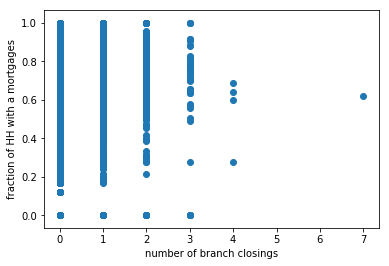

In [6]:
# scatterplot to have a first impact
plt.scatter(df.num_closings, df.pmortgage)
plt.xlabel('number of branch closings')
plt.ylabel('fraction of HH with a mortgages')

## Replication of Summary Stats

In [7]:
# Table 1: Merger Sample
df = pd.read_stata('data/replication_input.dta')
df = df[['acq_instname', 'out_instname', 'yr_approve', 'approved']]
df.drop_duplicates(keep='first', inplace=True)
df = df.sort_values(by='approved')
df = df[['acq_instname', 'out_instname', 'yr_approve']]
pd.options.display.float_format = '{:.0f}'.format
df = df.rename(index=str , columns={'acq_instname':'Buyer', 'out_instname':'Target', 'yr_approve':'Year approved'})
print(df.to_string(index=False))

                                   Buyer                                             Target  Year approved
 Manufacturers and Traders Trust Company                                      Allfirst Bank           2003
   Bank of America, National Association                                Fleet National Bank           2004
                      National City Bank                                 The Provident Bank           2004
                            Regions Bank          Union Planters Bank, National Association           2004
                     JPMorgan Chase Bank                     Bank One, National Association           2004
                         North Fork Bank                                    GreenPoint Bank           2004
                           SunTrust Bank                          National Bank of Commerce           2004
     Wachovia Bank, National Association                                    SouthTrust Bank           2004
                          Sovereign B

In [8]:
# Table 2: Merger Sammary Statistics
df = pd.read_stata('data/replication_input.dta')
df = df.filter(regex='mergerID|premerger_acq|premerger_out')
df.drop_duplicates(keep='first', inplace=True)
df_t = pd.DataFrame(columns=['Variable', 'Median', 'Min', 'Max'])
df = df.filter(regex='premerger_acq|premerger_out')
df_t['Variable'] = ['Total assets', 'Branches', 'States of operation', 'Countries of operation', 'Total assets', 'Branches', 'States of operation', 'Countries of operation']
df_t['Median']   = np.round(np.median(df, axis=0))
df_t['Min']      = np.round(np.nanmin(df, axis=0))
df_t['Max']      = np.round(np.nanmax(df, axis=0))
print(df_t.to_string(index=False))
#np.round(df.describe(percentiles=[.5]), 1).T # we only need min, 50% (median), max

               Variable   Median       Min         Max
           Total assets 81954710  25963401  1252402412
               Branches      696       254        5569
    States of operation        8         1          31
 Countries of operation      182        18         692
           Total assets 25955711  10426963   245783000
               Branches      277        28        1482
    States of operation        6         1          13
 Countries of operation       54         7         202


In [11]:
# todo add standard devidations in brackets
# Table 3: Summary Statistics for Exposed and Control Tracts
#df.assign(cntyID = df.sort_values(['state_fps', 'cnty_fps']))
filter_cols = 'poptot|popdensity|pminority|pcollege|pincome|medincome|pmortgage|cont_totalbranches|cont_brgrowth|cont_total_origin|cont_NumSBL_Rev1|Obs'
df = pd.read_stata('data/mergersample_controls.dta')
index = ['popdensity','poptot','medincome','pminority','pcollege','pmortgage','pincome','cont_totalbranches', 'cont_brgrowth','cont_NumSBL_Rev1','cont_total_origin']
df_t = pd.DataFrame(columns=['Variable', 'Exposed', 'All other', 'p-value 01', 'Control', 'p-value 02'], index=index)
df.drop_duplicates(keep='first', inplace=True)
df_exposed = df.loc[df.overlap==1]
df_exposed=df_exposed.assign(Obs=lambda df_exposed:len(df_exposed))
df_exposed = df_exposed.filter(regex=filter_cols).T
df = pd.read_stata('data/mergersample_controls.dta')
df.drop_duplicates(keep='first', inplace=True)
df_all     = df.loc[df.overlap==0]
df_all=df_all.assign(Obs=lambda df_all:len(df_all))
df_all     = df_all.filter(regex=filter_cols).T
df01 = pd.read_stata('data/replication_input.dta')
df01 = df01.filter(regex='state_fps|cnty_fps|tractstring|overlap|mergerID')
df01.drop_duplicates(keep='first', inplace=True)
df02 = pd.read_stata('data/mergersample_controls.dta')
df02.drop_duplicates(keep='first', inplace=True)
#df = pd.merge(df01,df02,  on=['state_fps','cnty_fps','tractstring','mergerID'], how='inner', suffixes=('', '_y'))
df = pd.merge(df01,df02,  on=['state_fps','cnty_fps','tractstring','mergerID'], how='inner')
df = df.loc[df.overlap_y==0]
df_control = df.groupby(['state_fps','cnty_fps'], as_index=True)
#df_control = df.groupby('state_fps')
df_control = df_control.agg(np.mean)
df_control = df.assign(Obs=lambda df:len(df))
df_control = df_control.filter(regex=filter_cols).T
df = df.filter(regex=filter_cols)
df_t['Variable']  = list(df)
df_t              = df_t.append({'Variable':'Obs'}, ignore_index=True)
df_t['Exposed']   = np.round(np.nanmean(df_exposed, axis=1), decimals=3)
df_t['All other'] = np.round(np.nanmean(df_all, axis=1), decimals=3)
ptemp = stats.ttest_ind(df_exposed, df_all, axis=1, equal_var=True, nan_policy='omit')
df_t['p-value 01']   = np.round(np.ma.getdata(ptemp[1]), decimals=3)
df_t['Control']   = np.round(np.nanmean(df_control, axis=1), decimals=3)
ptemp = stats.ttest_ind(df_exposed, df_control, axis=1, equal_var=True, nan_policy='omit')
df_t['p-value 02']   = np.round(np.ma.getdata(ptemp[1]), decimals=3)
filter_cols = ['poptot','popdensity','pminority','pcollege','pincome','medincome','pmortgage','cont_totalbranches','cont_brgrowth','cont_total_origin','cont_NumSBL_Rev1']
print(df_t.to_string(index=False))
#print(df_control)
#np.shape(ptemp)

           Variable  Exposed  All other  p-value 01  Control  p-value 02
         popdensity     2575       7206           0     6106           0
             poptot     5761       4572           0     5388           0
          medincome    44224      45452           0    52171           0
          pminority        0          0           0        0           0
           pcollege        0          0           0        0           0
          pmortgage        1          1           0        1           0
            pincome      114        102           0      119           0
 cont_totalbranches        6          1           0        4           0
      cont_brgrowth        0          0           0        0           0
   cont_NumSBL_Rev1      103         54           0       89           0
  cont_total_origin      277        227           0      281           1
                Obs      386      18027         nan     3087         nan


In [12]:
# todo add standard devidations in brackets
# Table 4: Representativeness of the Merger Sample
filter_cols = 'poptot|popdensity|pminority|pcollege|pincome|medincome|pmortgage|cont_totalbranches|cont_brgrowth|cont_total_origin|cont_NumSBL_Rev1|Obs'
df = pd.read_stata('data/alltract_controls.dta')
#index = ['popdensity','poptot','medincome','pminority','pcollege','pmortgage','pincome','cont_totalbranches', 'cont_brgrowth','cont_NumSBL_Rev1','cont_total_origin']
index = ['popdensity', 'poptot', 'medincome', 'pminority', 'pcollege', 'pmortgage', 'totalbranches', 'brgrowth', 'NumSBL_Rev1', 'total_origin', 'pincome', 'Obs']
df_t = pd.DataFrame(columns=['Variable', 'All', 'Closings', 'Merger'], index=index)
df.drop_duplicates(keep='first', inplace=True)

df_all = df.loc[df['year']>=2002]
df_all = df_all.loc[df_all['year']<=2007]
df_all = df_all.groupby(['state_fps', 'cnty_fps', 'tractstring'])
df_all = df_all.agg(np.nanmax)
#df_all = df_all.agg(np.nanmean)
df_all = df_all.loc[df_all['totalbranches']>0]
df_all['Obs'] = len(df_all)
df_all = df_all.agg(np.nanmean)
alltract_index = 'popdensity|poptot|medincome|pminority|pcollege|pmortgage|totalbranches|brgrowth|NumSBL_Rev1|total_origin|pincome|Obs'
df_all = df_all.filter(regex=alltract_index)

df_closing = df.loc[df['year']>=2002]
df_closing = df_closing.loc[df_closing['year']<=2007]
df_closing = df_closing.groupby(['state_fps', 'cnty_fps', 'tractstring'])
df_closing = df_closing.agg(np.nanmax)
df_closing = df_closing.loc[df_closing['num_closings']>0]
df_closing['Obs'] = len(df_closing)
df_closing = df_closing.agg(np.nanmean)
df_closing = df_closing.filter(regex=alltract_index).T

df = pd.read_stata('data/replication_input.dta')
#df_merger      = df.loc[df['year']==2001]
df_merger = df.loc[df['year']>=2002]
df_merger = df_merger.loc[df_merger['year']<=2007]
df01 = pd.read_stata('data/alltract_controls.dta')
df01.drop_duplicates(keep='first', inplace=True)
df_merger = pd.merge(df_merger,df01,  on=['state_fps','cnty_fps','tractstring'], how='inner', suffixes=('', '_y'))
df_merger = df_merger.groupby(['state_fps', 'cnty_fps', 'tractstring'])
df_merger = df_merger.agg(np.nanmax)
num= len(df_merger)
df_merger = df_merger.agg(np.nanmean)
df_merger.rename(index= {'cont_totalbranches': 'totalbranches', 'cont_brgrowth':'brgrowth', 'cont_NumSBL_Rev1':'NumSBL_Rev1','cont_total_origin':'total_origin'},  inplace = True)
df_merger = df_merger.filter(regex=alltract_index).T
df_merger = df_merger.iloc[4:15]
df_merger['Obs'] = num

df_t['Variable']  = list(index)
df_t['All']       = np.round(df_all, decimals=3)
df_t['Closings']  = np.round(df_closing, decimals=3)
df_t['Merger']    = np.round(df_merger, decimals=3)

print(df_t.to_string(index=False))

      Variable   All  Closings  Merger
    popdensity  4032      3615    6166
        poptot  4688      4942    5401
     medincome 44829     45249   51803
     pminority     0         0       0
      pcollege     0         0       0
     pmortgage     1         1       1
 totalbranches     3         4       4
      brgrowth     0         0       0
   NumSBL_Rev1    89       106      92
  total_origin   318       343     282
       pincome   104       106     119
           Obs 37041      7768    3003
